# Time Series Temperature

Muhammad Ghifari Zuhir

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, LSTM
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dicoding/timeseries/daily-min-temperatures.csv')

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    
    return ds.batch(batch_size).prefetch(1)

In [ ]:
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


Text(0.5, 1.0, 'Temperature average')

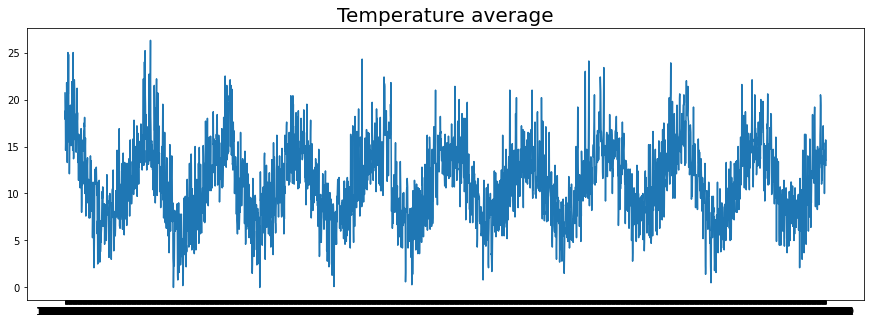

In [ ]:
dates = df['Date'].values
temp_dataset  = df['Temp'].values
  
  
plt.figure(figsize=(15,5))
plt.plot(dates, temp_dataset)
plt.title('Temperature average', fontsize=20)

In [ ]:
split_data = np.random.rand(len(df)) <= 0.8

train = df[split_data]
val = df[~split_data]

temp_train = train.Temp.values
temp_val = val.Temp.values

In [ ]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temp,2928.0,11.194296,4.072686,0.0,8.3,11.0,14.0,25.2


In [ ]:
print("jumlah data train",len(train))
print("jumlah data val",len(val))

jumlah data train 2928
jumlah data val 722


In [ ]:
train_set = windowed_dataset(temp_train, window_size=60, batch_size=16, shuffle_buffer=1000)
val_set = windowed_dataset(temp_val, window_size=60, batch_size=16, shuffle_buffer=1000)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(25, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=7.0000e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=7)

history = model.fit(train_set,
                    validation_data = val_set,
                    callbacks = [es],
                    epochs=300)

Epoch 1/300
180/180 [==============================] - 15s 65ms/step - loss: 2.7955 - mae: 3.2635 - val_loss: 4.4663 - val_mae: 4.9487
Epoch 2/300
180/180 [==============================] - 11s 61ms/step - loss: 2.7819 - mae: 3.2493 - val_loss: 2.1468 - val_mae: 2.6036
Epoch 3/300
180/180 [==============================] - 11s 59ms/step - loss: 2.7122 - mae: 3.1798 - val_loss: 2.0903 - val_mae: 2.5435
Epoch 4/300
180/180 [==============================] - 11s 61ms/step - loss: 2.6952 - mae: 3.1591 - val_loss: 2.0855 - val_mae: 2.5427
Epoch 5/300
180/180 [==============================] - 11s 60ms/step - loss: 2.6039 - mae: 3.0669 - val_loss: 2.1158 - val_mae: 2.5730
Epoch 6/300
180/180 [==============================] - 11s 60ms/step - loss: 2.6262 - mae: 3.0898 - val_loss: 2.1929 - val_mae: 2.6500
Epoch 7/300
180/180 [==============================] - 11s 60ms/step - loss: 2.6242 - mae: 3.0910 - val_loss: 2.2380 - val_mae: 2.6983
Epoch 8/300
180/180 [==============================] - 

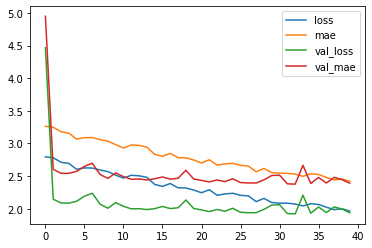

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()